In [1]:
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

class APTOSDataset_(Dataset):
    def __init__(self, image_dir, csv_path, train_ratio=0.75, train=True, transform=None):
        self.image_dir = image_dir
        self.transform = transform

        df = pd.read_csv(csv_path)
        df = df[['id_code', 'label']].copy()
        df['id_code'] = df['id_code'].apply(lambda x: f"{x}.png" if not x.endswith('.png') else x)

        available_images = set(os.listdir(image_dir))
        df = df[df['id_code'].isin(available_images)].reset_index(drop=True)

        images = df['id_code'].tolist()
        labels = df['label'].tolist()

        # train/test split
        train_imgs, test_imgs, train_labels, test_labels = train_test_split(
            images, labels, train_size=train_ratio,
            stratify=labels, random_state=34
        )
        self.image_files = train_imgs if train else test_imgs
        self.labels = train_labels if train else test_labels

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, torch.tensor(label, dtype=torch.long)

In [2]:
# ============================= 기존 결과 매핑 =============================
# array([['파일명', GT, Adapter Pred, Direct Pred, Agreement], ...])
pred_results = [
    ['5257cb536da2.png', 0, 0, 1, False],
    ['5cc6dea19614.png', 1, 1, 0, False],
    ['4a589edaea60.png', 0, 0, 1, False],
    ['f3a88d3026dc.png', 1, 0, 1, False],
    ['ae8424cdb029.png', 1, 1, 0, False],
    ['cd29c88c9e36.png', 1, 1, 0, False],
    ['09935d72892b.png', 1, 0, 1, False],
    ['fce73678f650.png', 0, 0, 1, False],
    ['8bdb891661a8.png', 1, 1, 0, False],
    ['77e7c7a160c8.png', 1, 1, 0, False],
    ['3f5b4c2948e8.png', 1, 0, 1, False],
    ['e2c3b037413b.png', 0, 1, 0, False],
    ['afc345cc9145.png', 0, 1, 0, False],
    ['f72adcac5638.png', 1, 1, 0, False],
    ['2cfe8703f265.png', 0, 0, 1, False],
    ['144a1a426137.png', 1, 1, 0, False],
    ['a2d349f567a6.png', 1, 1, 0, False],
    ['2a47e5b21791.png', 1, 0, 1, False],
]

# filename 기준으로 lookup dict 생성
pred_results_map = {
    row[0]: {
        "gt": row[1],
        "adapter_pred": row[2],
        "direct_pred": row[3],
        "agreement": row[4]
    }
    for row in pred_results
}


In [ ]:
import sys
sys.path.append("/workspace/fed-mdmae")

import os
import torch
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import yaml
import torch.nn.functional as F
from torchvision import transforms
from pytorch_grad_cam import GradCAM, XGradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import torch.nn as nn

from models.mae import MaskedAutoencoderViT
from models.classifier import FineTunedMAE
from data.dataset_utils import *

# ============================= 설정 및 초기화 =============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = 'aptos'
img_dir = "/workspace/fed-mdmae/FL_QA-FedProto/visualization/sample_APTOS/images"
cfg_path = "/workspace/fed-mdmae/FL_QA-FedProto/visualization/configs.yaml"
global_model_path = "/workspace/fed-mdmae/FL_QA-FedProto/models/sample_models/global_model.pt"
save_root_dir = "/workspace/fed-mdmae/FL_QA-FedProto/visualization/cam_results"

# 모델 경로
adapter_model_path = "/workspace/fed-mdmae/FL_QA-FedProto/models/sample_models/Adapter_FT/best_model.pt"
direct_model_path = "/workspace/fed-mdmae/FL_QA-FedProto/models/sample_models/FFT/best_model.pt"

# 데이터셋 정규화 값
DATASET_MEAN = [0.48177003860473633, 0.2620476186275482, 0.0985482931137085]
DATASET_STD = [0.23788580298423767, 0.13709917664527893, 0.05762823671102524]

/root/miniconda3/envs/jm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# ============================= 유틸리티 함수 =============================
def normalize_heatmap(heatmap):
    """통일된 히트맵 정규화"""
    if isinstance(heatmap, torch.Tensor):
        heatmap = heatmap.detach().cpu().numpy()
    
    hmin, hmax = heatmap.min(), heatmap.max()
    if hmax - hmin < 1e-8:
        return np.zeros_like(heatmap)
    
    return (heatmap - hmin) / (hmax - hmin)

def apply_heatmap_overlay(original_img, heatmap, alpha=0.4):
    """원본 이미지에 히트맵 오버레이 적용"""
    # 원본 이미지 전처리
    if isinstance(original_img, np.ndarray):
        rgb_img = original_img.astype(np.float32) / 255.0
    else:
        rgb_img = np.array(original_img).astype(np.float32) / 255.0
    
    # 히트맵 처리 및 크기 맞추기
    heatmap_norm = normalize_heatmap(heatmap)
    
    # 히트맵을 원본 이미지 크기로 리사이즈
    if heatmap_norm.shape != rgb_img.shape[:2]:
        heatmap_norm = cv2.resize(heatmap_norm, (rgb_img.shape[1], rgb_img.shape[0]), interpolation=cv2.INTER_CUBIC)
    
    heatmap_colored = cv2.applyColorMap((heatmap_norm * 255).astype(np.uint8), cv2.COLORMAP_JET)
    heatmap_rgb = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB) / 255.0
    
    # 오버레이 생성
    overlay = np.clip(heatmap_rgb * alpha + rgb_img * (1 - alpha), 0, 1)
    return (overlay * 255).astype(np.uint8)

def get_ground_truth_label(dataset, img_path, cfg_path):
    """Ground truth 라벨 추출"""
    with open(cfg_path, 'r') as f:
        cfg = yaml.safe_load(f)
    
    if dataset == 'aptos':
        df = pd.read_csv(cfg['CSV_DIR'])
        df = df[['id_code', 'label']].copy()
        df['id_code'] = df['id_code'].apply(lambda x: f"{x}.png" if not x.endswith('.png') else x)
        
        filename = os.path.basename(img_path)
        matching_row = df[df['id_code'] == filename]
        if len(matching_row) > 0:
            return int(matching_row.iloc[0]['label'])
    
    return None

In [5]:
# ============================= 모델 클래스 정의 =============================
class EncoderAdapterWrapper(torch.nn.Module):
    """Adapter 기반 모델 래퍼"""
    def __init__(self, encoder, adapter, head):
        super().__init__()
        self.encoder = encoder
        self.adapter = adapter
        self.head = head

    def forward(self, x):
        x = self.encoder.patch_embed(x)
        cls_token = self.encoder.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_token, x), dim=1) + self.encoder.pos_embed
        for blk in self.encoder.blocks:
            x = blk(x)
        x = self.encoder.norm(x)
        x = x[:, 1:, :]
        B, N, C = x.shape
        h = w = int(N ** 0.5)
        x = x.permute(0, 2, 1).reshape(B, C, h, w)
        feat_map = self.adapter(x)
        gap = feat_map.mean(dim=[2, 3])
        return self.head(gap)

class MAEEncoder(nn.Module):
    """Attention Rollout을 위한 MAE Encoder 래퍼"""
    def __init__(self, fine_tuned_mae):
        super().__init__()
        self.patch_embed = fine_tuned_mae.patch_embed
        self.cls_token = fine_tuned_mae.cls_token
        self.pos_embed = fine_tuned_mae.pos_embed
        self.pos_drop = fine_tuned_mae.pos_drop
        self.blocks = fine_tuned_mae.blocks
        self.norm = fine_tuned_mae.norm

    def forward_encoder_with_attn(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        attn_list = []
        for blk in self.blocks:
            x, attn = blk(x, return_attn=True)
            attn_list.append(attn)

        x = self.norm(x)
        return x, attn_list

In [7]:
# ============================= XGradCAM 함수 =============================
def get_xgradcam_heatmap(model, input_tensor, target_layer, pred_class):
    """XGradCAM 히트맵 생성"""
    cam = XGradCAM(model=model, target_layers=[target_layer])
    targets = [ClassifierOutputTarget(pred_class)]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
    
    del cam
    torch.cuda.empty_cache()
    return grayscale_cam

# ============================= Attention Rollout 함수 =============================
def compute_rollout_attention(attn_matrices, add_residual=True):
    """Attention Rollout 계산"""
    result = torch.eye(attn_matrices[0].size(-1)).to(attn_matrices[0].device)
    for attn in attn_matrices:
        attn_heads_fused = attn.mean(dim=1)
        if add_residual:
            attn_heads_fused += torch.eye(attn_heads_fused.size(-1)).to(attn.device)
        attn_heads_fused /= attn_heads_fused.sum(dim=-1, keepdim=True)
        result = attn_heads_fused @ result
    return result

def modify_blocks_for_attention(model):
    """기존 모델 블록을 attention 추출 가능하도록 수정"""
    def create_forward_with_attn(original_forward):
        def forward_with_attn(self, x, return_attn=False):
            if return_attn:
                x_norm = self.norm1(x)
                B, N, C = x_norm.shape
                qkv = self.attn.qkv(x_norm).reshape(B, N, 3, self.attn.num_heads, C // self.attn.num_heads).permute(2, 0, 3, 1, 4)
                q, k, v = qkv.unbind(0)
                attn = (q @ k.transpose(-2, -1)) * self.attn.scale
                attn = attn.softmax(dim=-1)
                x_attn = (attn @ v).transpose(1, 2).reshape(B, N, C)
                x_attn = self.attn.proj(x_attn)
                x = x + x_attn
                x = x + self.mlp(self.norm2(x))
                return x, attn
            else:
                return original_forward(x)
        return forward_with_attn
    
    for block in model.blocks:
        original_forward = block.forward
        new_forward = create_forward_with_attn(original_forward)
        block.forward = new_forward.__get__(block, block.__class__)

def get_attention_rollout_heatmap(model, input_tensor):
    """Attention Rollout 히트맵 생성"""
    model.eval()
    with torch.no_grad():
        _, attn_list = model.forward_encoder_with_attn(input_tensor)
        rollout = compute_rollout_attention(attn_list, add_residual=True)[0]
        cls_attn = rollout[0, 1:].reshape(14, 14).cpu().numpy()
    
    return cls_attn

처리 중: 2a47e5b21791.png
  XGradCAM 처리 중...
  Attention Rollout 처리 중...
  완료 - Adapter: 0, Direct: 1, GT: 1
처리 중: 2cfe8703f265.png
  XGradCAM 처리 중...
  Attention Rollout 처리 중...
  완료 - Adapter: 0, Direct: 1, GT: 0
처리 중: 144a1a426137.png
  XGradCAM 처리 중...
  Attention Rollout 처리 중...
  완료 - Adapter: 1, Direct: 0, GT: 1
처리 중: 3f5b4c2948e8.png
  XGradCAM 처리 중...
  Attention Rollout 처리 중...
  완료 - Adapter: 0, Direct: 1, GT: 1
처리 중: 4a589edaea60.png
  XGradCAM 처리 중...
  Attention Rollout 처리 중...
  완료 - Adapter: 0, Direct: 1, GT: 0
최종 시각화 생성 중...


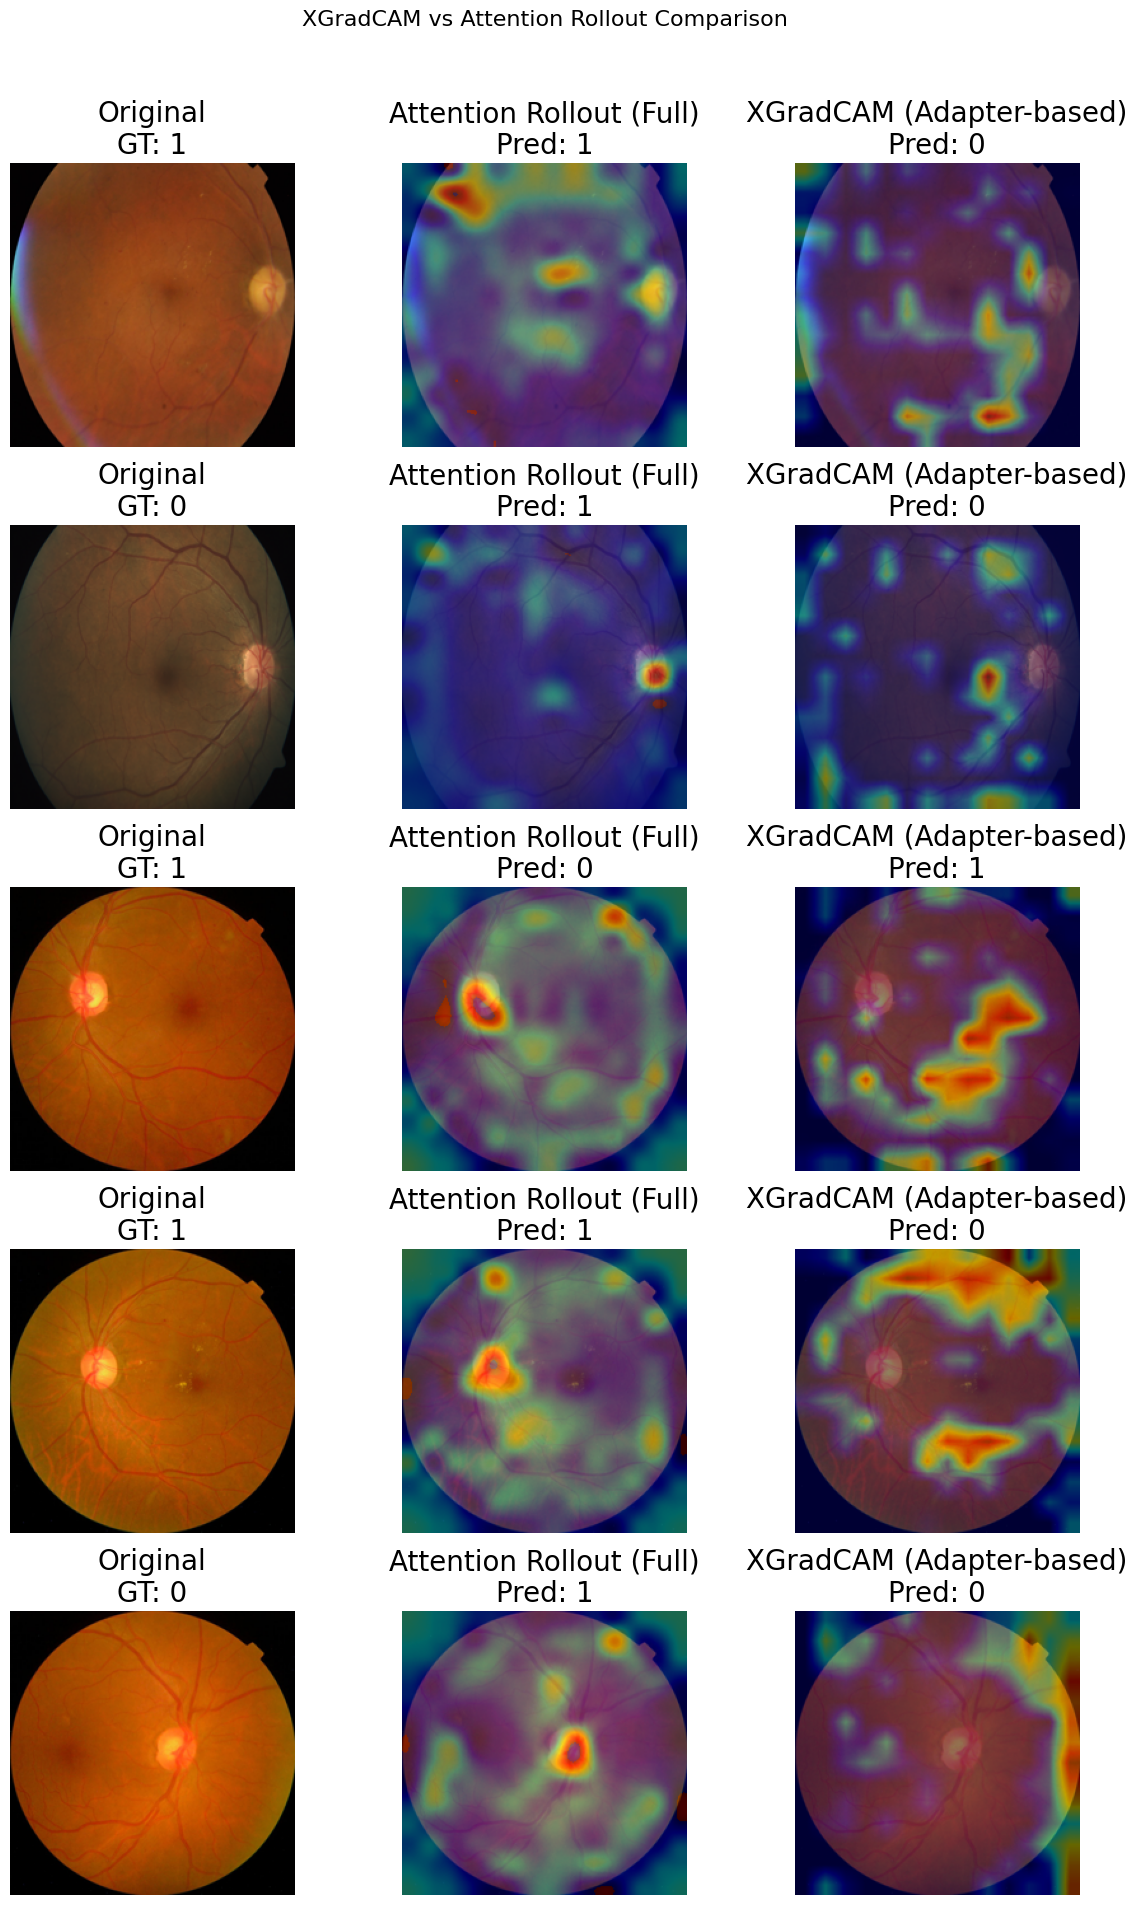

시각화 저장 완료: /workspace/fed-mdmae/FL_QA-FedProto/visualization/cam_results/integrated_comparison.png


In [8]:
# ============================= 메인 시각화 함수 =============================
def visualize_integrated_comparison():
    """통합 비교 시각화 실행"""


    # 전처리 변환
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(DATASET_MEAN, DATASET_STD)
    ])
    
    results = []

    # test dataset 생성
    with open(cfg_path, 'r') as f:
        cfg = yaml.safe_load(f)
    csv_path = cfg['CSV_DIR']

    test_dataset = APTOSDataset_(
        image_dir=img_dir,
        csv_path=csv_path,
        train_ratio=0.75,   # 학습/테스트 분할 비율
        train=False,        # test split만 가져오기
        transform=transform      # 시각화니까 raw 이미지 그대로 씀
    )


    img_list = test_dataset.image_files
    
    for fname in img_list:
        img_path = os.path.join(img_dir, fname)
        print(f"처리 중: {fname}")
        
        raw_image = Image.open(img_path).convert("RGB")
        input_tensor = transform(raw_image).unsqueeze(0).to(device)
        original_img = np.array(raw_image.resize((224, 224)))

        # Ground truth 및 예측 결과 가져오기
        mapped = pred_results_map[fname]
        gt_label = mapped["gt"]
        pred_class_adapter = mapped["adapter_pred"]
        pred_class_direct = mapped["direct_pred"]

        # CAM/Attention 시각화 (추론 제거, 시각화용 forward만 수행)
        print("  XGradCAM 처리 중...")
        mae_encoder = MaskedAutoencoderViT(
            img_size=224, patch_size=16, in_chans=3,
            embed_dim=768, depth=12, num_heads=12,
            decoder_embed_dim=512, decoder_depth=8,
            decoder_num_heads=16, mlp_ratio=4,
            norm_layer=torch.nn.LayerNorm
        )
        mae_encoder.load_state_dict(torch.load(global_model_path, map_location=device))
        mae_encoder.to(device).eval()

        adapter_model = torch.load(adapter_model_path, map_location=device, weights_only=False)
        adapter_model.to(device).eval()
        wrapped_adapter = EncoderAdapterWrapper(mae_encoder, adapter_model.adapter, adapter_model.head).to(device).eval()
        target_layer = adapter_model.adapter[3]

        xgradcam_heatmap = get_xgradcam_heatmap(wrapped_adapter, input_tensor, target_layer, pred_class_adapter)
        xgradcam_overlay = apply_heatmap_overlay(original_img, xgradcam_heatmap)

        del mae_encoder, adapter_model, wrapped_adapter
        torch.cuda.empty_cache()

        print("  Attention Rollout 처리 중...")
        direct_model = torch.load(direct_model_path, map_location="cpu")
        direct_model.to(device).eval()
        modify_blocks_for_attention(direct_model)
        wrapped_direct = MAEEncoder(direct_model).to(device)

        rollout_heatmap = get_attention_rollout_heatmap(wrapped_direct, input_tensor)
        rollout_overlay = apply_heatmap_overlay(original_img, rollout_heatmap)

        del direct_model, wrapped_direct
        torch.cuda.empty_cache()

        # 결과 저장 (확률 대신 매핑된 예측만 표시)
        results.append({
            'filename': fname,
            'original': original_img,
            'xgradcam': xgradcam_overlay,
            'rollout': rollout_overlay,
            'adapter_pred_class': pred_class_adapter,
            'rollout_pred_class': pred_class_direct,
            'gt_label': gt_label
        })

        print(f"  완료 - Adapter: {pred_class_adapter}, Direct: {pred_class_direct}, GT: {gt_label}")

    # ===== 최종 시각화 =====
    print("최종 시각화 생성 중...")

    num_images = len(results)
    fig, axes = plt.subplots(num_images, 3, figsize=(12, num_images * 4))  # <-- (행, 열) 순서 변경

    if num_images == 1:
        axes = axes.reshape(1, 3)  # 1개만 있을 때 shape 맞추기

    for i, result in enumerate(results):
        # 원본 이미지
        axes[i, 0].imshow(result['original'])
        axes[i, 0].set_title(f"Original\nGT: {result['gt_label']}", fontsize=20)
        axes[i, 0].axis('off')
    
        
        # Attention Rollout
        axes[i, 1].imshow(result['rollout'])
        axes[i, 1].set_title(f"Attention Rollout (Full)\nPred: {result['rollout_pred_class']}", fontsize=20)
        axes[i, 1].axis('off')

            # XGradCAM
        axes[i, 2].imshow(result['xgradcam'])
        axes[i, 2].set_title(f"XGradCAM (Adapter-based)\nPred: {result['adapter_pred_class']}", fontsize=20)
        axes[i, 2].axis('off')

    plt.suptitle("XGradCAM vs Attention Rollout Comparison", fontsize=16, y=0.95)
    plt.tight_layout(rect=[0, 0, 1, 0.93])

    # 저장
    os.makedirs(save_root_dir, exist_ok=True)
    save_path = os.path.join(save_root_dir, "integrated_comparison.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"시각화 저장 완료: {save_path}")


# ============================= 실행 =============================
if __name__ == "__main__":
    visualize_integrated_comparison()